In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio

pio.renderers.default = "svg"

In [52]:
inf = pd.read_csv("../data/raw/cam-inflation-2005-2025.csv")
exp = pd.read_csv("../data/raw/export-2015-2025.csv")
fuel = pd.read_csv("../data/raw/fuel-price-2023-2025.csv").sort_values(by="Start_Date")
imp = pd.read_csv("../data/raw/import-2015-2025.csv")
exch = pd.read_csv("../data/raw/khr-usd-exchange-2003-2023.csv") 

## Study Relationship between Inflation and Fuel

In [53]:
inf['Date'] = pd.to_datetime(inf['Date'], dayfirst=True)
fuel['Start_Date'] = pd.to_datetime(fuel['Start_Date'])

In [54]:
display(inf.head())
display(fuel.head())

,Date,CPI_all_item,MoM_Change_CPI_all_item,YoY_Change_CPI_all_item,Three_Month_Avg_YoY,Twelve_Month_Avg_YoY
0,2005-01-22,87.98,0.14,5.12,5.28,4.32
1,2005-02-22,88.39,0.47,5.35,5.25,4.71
2,2005-03-22,88.63,0.27,5.09,5.19,5.08
3,2005-04-22,90.26,1.83,6.15,5.53,5.48
4,2005-05-22,91.01,0.84,6.67,5.97,5.86


,Start_Date,End_Date,Gasoline_92_Unit_Price,Gasoline_92_Unit_Price_Change,Gasoil_50ppm_Unit_Price,Gasoil_50ppm_Unit_Price_Change,Source_Link
73,2023-01-01,2023-01-10,4200.0,NaN,4550.0,NaN,https://www.moc.gov.kh/news/591
72,2023-01-11,2023-01-20,4200.0,0.0,4400.0,-150.0,https://www.moc.gov.kh/news/605
71,2023-01-21,2023-01-31,4400.0,200.0,4600.0,200.0,https://www.moc.gov.kh/news/619
70,2023-02-01,2023-02-10,4767.0,367.0,4917.0,317.0,https://www.moc.gov.kh/news/639
69,2023-02-11,2023-02-20,4400.0,-367.0,4350.0,-567.0,https://www.moc.gov.kh/news/658


In [55]:
fuel['Start_Date'] = pd.to_datetime(fuel['Start_Date'])
fuel_monthly = (
    fuel
    .set_index('Start_Date')
    .resample('ME')           
    .mean(numeric_only=True)          
    .reset_index()
)
fuel_monthly = fuel_monthly.drop(columns=["Gasoline_92_Unit_Price_Change", "Gasoil_50ppm_Unit_Price_Change"])
print(fuel_monthly.shape)
fuel_monthly.head()

(30, 3)


,Start_Date,Gasoline_92_Unit_Price,Gasoil_50ppm_Unit_Price
0,2023-01-31,4266.666667,4516.666667
1,2023-02-28,4583.500000,4633.500000
2,2023-03-31,4356.500000,4256.500000
3,2023-04-30,4425.000000,4100.000000
4,2023-05-31,4100.000000,3825.000000


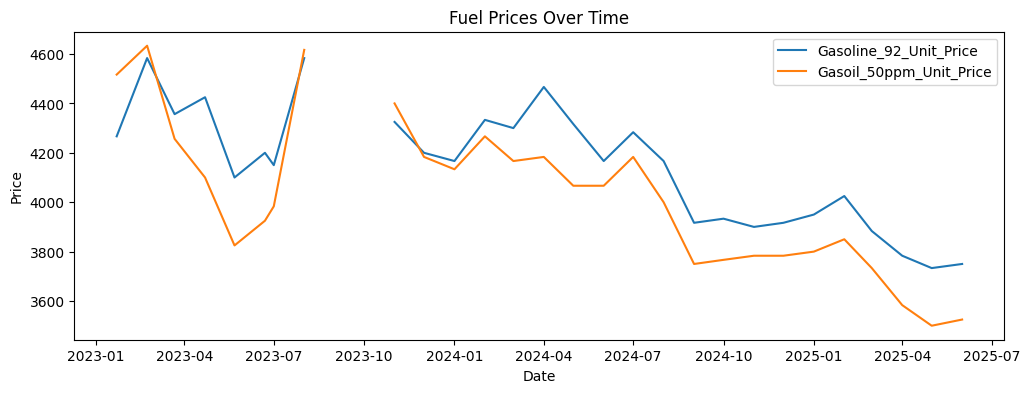

In [56]:
fuel_monthly['year'] = fuel_monthly['Start_Date'].dt.year
fuel_monthly['month'] = fuel_monthly['Start_Date'].dt.month

inf['year'] = inf['Date'].dt.year
inf['month'] = inf['Date'].dt.month
inf = inf.drop(columns=['MoM_Change_CPI_all_item', 'YoY_Change_CPI_all_item', 'Three_Month_Avg_YoY', 'Twelve_Month_Avg_YoY'])

fuel_inf = pd.merge(
    inf,
    fuel_monthly,
    on=['year', 'month'],
    how='inner'
)

features = ["Gasoline_92_Unit_Price", "Gasoil_50ppm_Unit_Price"]
plt.figure(figsize=(12,4))

for col in features:
    plt.plot(fuel_inf['Date'], fuel_inf[col], label=col)

plt.title("Fuel Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [58]:
fuel_inf.drop(columns=['year', 'month', 'Start_Date'], inplace=True)

In [60]:
fuel_inf.to_csv("../data/merged/fuel-inflation-2023-2025.csv", index=False)

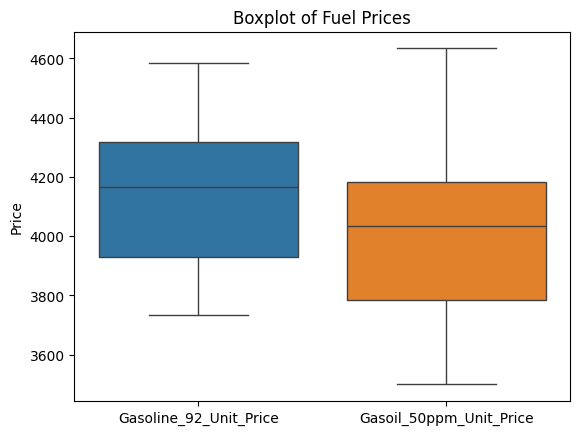

In [61]:
sns.boxplot(data=fuel_inf[features])
plt.title("Boxplot of Fuel Prices")
plt.ylabel("Price")
plt.show()

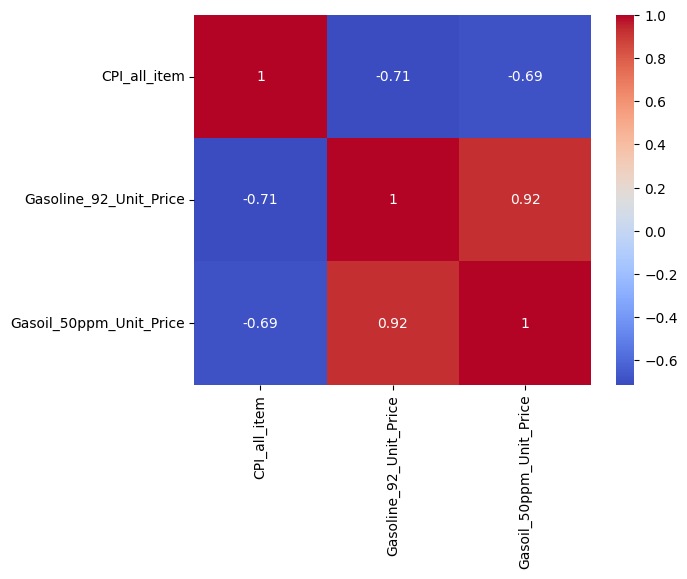

In [62]:
fuel_inf = fuel_inf.select_dtypes(include=["float64"])
sns.heatmap(fuel_inf.corr(), annot=True, cmap='coolwarm')
plt.show()

> CPI and Gasoline Prices have a negative correlation.

## Study Relationship between Inflation and Import, Export

In [63]:
monthly_exp = (
    exp.groupby(['year', 'month_num'], as_index=False)
       .agg({'value_thousand_usd': 'sum'})
)

monthly_imp = (
    imp.groupby(['year', 'month_num'], as_index=False)
       .agg({'value_thousand_usd': 'sum'})
)

monthly_exp = monthly_exp.rename(columns={'month_num': 'month', 'value_thousand_usd': 'value_thousand_usd_exp'})
monthly_imp = monthly_imp.rename(columns={'month_num': 'month', 'value_thousand_usd': 'value_thousand_usd_imp'})

display(monthly_exp.head())
display(monthly_imp.head())

,year,month,value_thousand_usd_exp
0,2015,1,691813.99206
1,2015,2,522931.74188
2,2015,3,526926.92383
3,2015,4,502114.13566
4,2015,5,629742.03940


,year,month,value_thousand_usd_imp
0,2015,1,702215.34953
1,2015,2,785599.99954
2,2015,3,792214.66959
3,2015,4,800527.77952
4,2015,5,849568.55397


In [18]:
cpi_exp = pd.merge(
    inf,
    monthly_exp,
    on=['year', 'month'],
    how='left'   
)

cpi_exp_imp = pd.merge(
    cpi_exp,
    monthly_imp,
    on=['year', 'month'],
    how='left',
    suffixes=('_exp', '_imp')  
)

cpi_features = cpi_exp_imp[['Date', 'CPI_all_item', 'value_thousand_usd_exp', 'value_thousand_usd_imp']].copy()
cpi_features = cpi_features.dropna().reset_index(drop=True)
cpi_features.head()

,Date,CPI_all_item,value_thousand_usd_exp,value_thousand_usd_imp
0,2015-01-22,156.61,691813.99206,702215.34953
1,2015-02-22,158.44,522931.74188,785599.99954
2,2015-03-22,158.58,526926.92383,792214.66959
3,2015-04-22,159.65,502114.13566,800527.77952
4,2015-05-22,159.77,629742.03940,849568.55397


In [34]:
cpi_features.to_csv("../data/merged/cpi-exp-imp-2015-2025.csv", index=False)

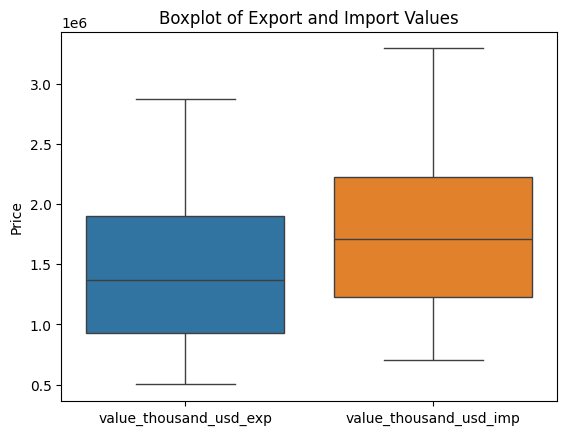

In [32]:
features = ["value_thousand_usd_exp", "value_thousand_usd_imp"]

sns.boxplot(data=cpi_features[features])
plt.title("Boxplot of Export and Import Values")
plt.ylabel("Price")
plt.show()

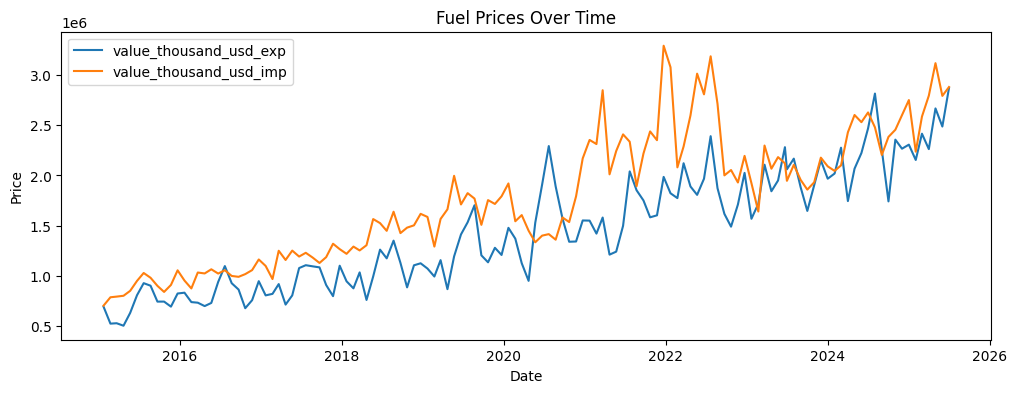

In [19]:

plt.figure(figsize=(12,4))

for col in features:
    plt.plot(cpi_features['Date'], cpi_features[col], label=col)

plt.title("Fuel Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

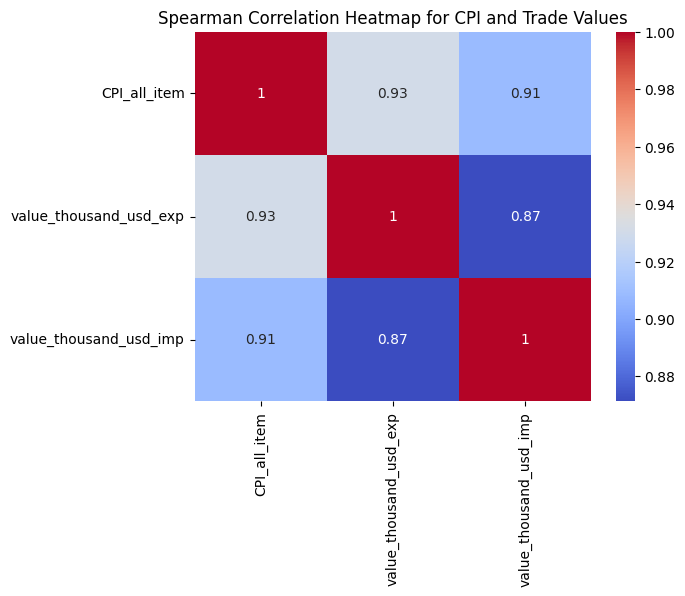

In [31]:
sns.heatmap(cpi_features.select_dtypes(include=["float64"]).corr(method="spearman"), annot=True, cmap='coolwarm')
plt.title("Spearman Correlation Heatmap for CPI and Trade Values")
plt.show()

> high positive correlation between CPI with import and export

## Study Relationship between Inflation and Exchange Rate

In [22]:
exch['Date'] = pd.to_datetime(exch['Date'], dayfirst=True)
exch['year'] = exch['Date'].dt.year
exch['month'] = exch['Date'].dt.month

monthly_exch = (
    exch.groupby(['year', 'month'], as_index=False)
        .agg({
            'Midpoint': 'mean',
            'Purchase': 'mean',
            'Sale': 'mean',
            'Exchange_Rate' : 'mean'
        })
)

monthly_exch.head()

,year,month,Midpoint,Purchase,Sale,Exchange_Rate
0,2003,4,3964.266667,3960.766667,3967.766667,3948.333333
1,2003,5,4021.725806,4016.451613,4027.000000,3980.000000
2,2003,6,4037.116667,4033.433333,4040.800000,4021.000000
3,2003,7,4000.838710,3996.903226,4004.774194,3989.032258
4,2003,8,4022.322581,4018.741935,4025.903226,4008.870968


In [23]:
cpi_exch = pd.merge(
    inf,                
    monthly_exch,        
    on=['year', 'month'],
    how='inner'         
)
cpi_exch = cpi_exch[['Date', 'CPI_all_item', 'Midpoint', 'Purchase', 'Sale', 'Exchange_Rate']].copy()
cpi_exch.head()

,Date,CPI_all_item,Midpoint,Purchase,Sale,Exchange_Rate
0,2005-01-22,87.98,4040.532258,4037.548387,4043.516129,4033.870968
1,2005-02-22,88.39,4037.357143,4034.178571,4040.535714,4033.464286
2,2005-03-22,88.63,4029.774194,4026.935484,4032.612903,4026.967742
3,2005-04-22,90.26,4037.383333,4033.733333,4041.033333,4029.266667
4,2005-05-22,91.01,4080.403226,4076.580645,4084.225806,4057.129032


In [36]:
cpi_exch.to_csv("../data/merged/cpi-exchange-2005-2025.csv", index=False)

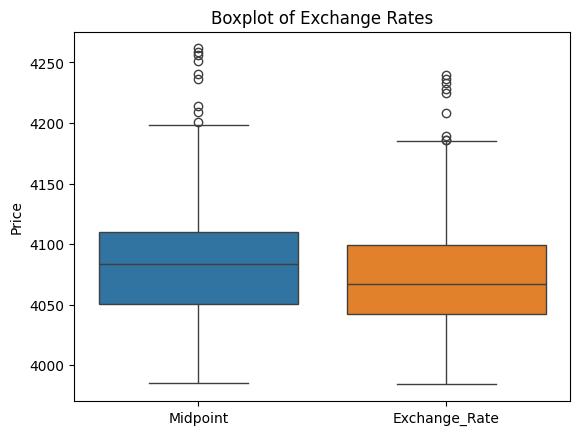

In [30]:
features = ['Midpoint', 'Exchange_Rate']

sns.boxplot(data=cpi_exch[features])
plt.title("Boxplot of Exchange Rates")
plt.ylabel("Price")
plt.show()

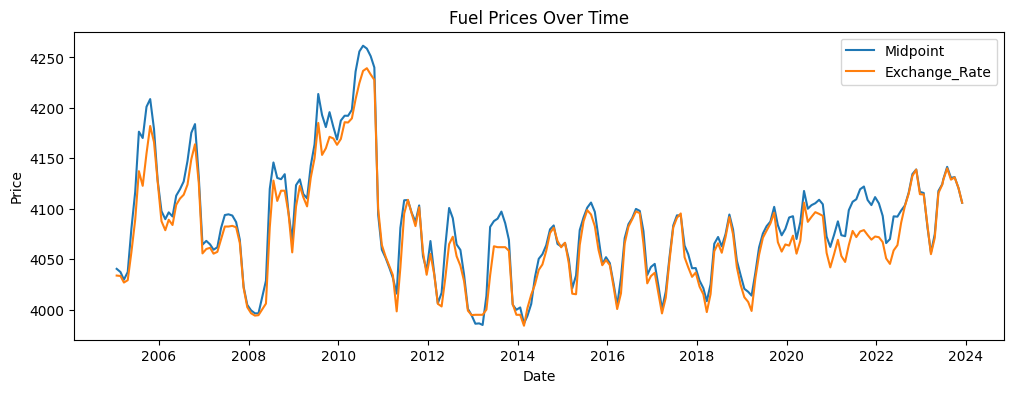

In [28]:

plt.figure(figsize=(12,4))

for col in features:
    plt.plot(cpi_exch['Date'], cpi_exch[col], label=col)

plt.title("Fuel Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

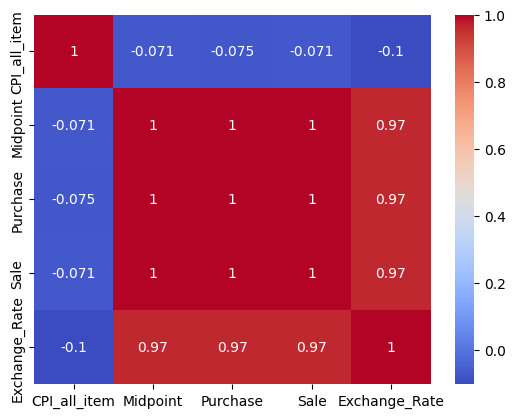

In [33]:
sns.heatmap(cpi_exch.select_dtypes(include=["float64"]).corr(method="spearman"), annot=True, cmap='coolwarm')
plt.show()